# [DL3] 과유불급
> **"SOTA 향한 집착: ResNet, Focal Loss, and The Lesson"**

### 👨‍💻 Developer's Log
- **Previous (DL2)**: 아주 훌륭했다. 하지만 만족할 수 없다. 더 쥐어짜면 더 나올 것 같다.
- **Hypothesis**: 모델을 더 깊게 쌓으면(Deep) 더 똑똑해지지 않을까? 어려운 문제만 집중적으로 파면(Focal) 다 맞추지 않을까?
- **Plan**: 남들이 좋다는 건 다 넣는다. **ResNet(Residual Connection)**과 **Focal Loss**로 이론상 '무적의 모델'을 만든다.


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

### 👨‍💻 Developer's Log: 데이터는 그대로
- DL2와 동일한 데이터를 사용한다. 그래야 모델의 순수한 변화를 볼 수 있다.

In [ ]:
print('>>> [MLP_advanced] Loading Data...')
base_path = '/Users/gimdabin/Deep-Learning/project_root/outputs/samples/'
anchors = pd.read_parquet(base_path + 'anchors.parquet')
features = pd.read_parquet(base_path + 'features_ml_clean.parquet')
labels = pd.read_parquet(base_path + 'labels.parquet')

anchors['user_id'] = anchors['user_id'].astype(str)
features['user_id'] = features['user_id'].astype(str)
labels['user_id'] = labels['user_id'].astype(str)

data = anchors.merge(features, on=['user_id', 'anchor_time'], how='inner')
data = data.merge(labels, on=['user_id', 'anchor_time'], how='inner')
data['target'] = (data['label'] == 'm2').astype(int)

feature_cols = [c for c in features.columns if c not in ['user_id', 'anchor_time']]
X = data[feature_cols].copy().fillna(0)
y = data['target'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_scaled), torch.FloatTensor(y_train_res)), batch_size=256, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.FloatTensor(X_val_scaled), torch.FloatTensor(y_val)), batch_size=256)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test_scaled), torch.FloatTensor(y_test)), batch_size=256)

>>> [DL3] Loading Data...


### 👨‍💻 Developer's Log: Focal Loss
- **문제**: 일반 Loss(BCE)는 쉬운 문제 100개 맞추는 걸 더 좋아한다.
- **해결**: `Focal Loss`를 구현한다. 이건 "이미 맞춘 문제는 점수 안 줘!"라고 하는 것과 같다. 모델이 틀린 문제(Hard Example)에만 미친듯이 집중하게 만든다.

In [5]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return torch.mean(F_loss)

### 👨‍💻 Developer's Log: ResNet (Deep Structure)
- **야망**: 층을 더 쌓고 싶다. 근데 그냥 쌓으면 학습이 안 된다(Vanishing Gradient).
- **해결**: 구글이 만든 **Residual Connection (Skip Connection)**을 쓴다. 입력값을 출력값에 바로 더해주는 '지름길'을 뚫으면, 이론상 100층도 쌓을 수 있다.
- **기대**: 엄청난 Feature Extraction 능력으로, 미세한 이탈 징후까지 잡아낼 것이다.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim)
        )
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        out = self.block(x)
        return self.relu(out + residual)

class AdvancedMLP_Logits(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_blocks=2):
        super(AdvancedMLP_Logits, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )
        self.blocks = nn.ModuleList([ResidualBlock(hidden_dim) for _ in range(num_blocks)])
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        out = self.input_layer(x)
        for block in self.blocks: 
            out = block(out)
        return self.output_layer(out)

model = AdvancedMLP_Logits(X.shape[1], hidden_dim=256, num_blocks=2)
criterion = FocalLoss(alpha=0.25, gamma=2.0)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

print('>>> Training MLP_advanced (Optimized MLP)...')
for epoch in range(15):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}: Loss {epoch_loss/len(train_loader):.4f}')

>>> Training DL3 (Optimized MLP)...
Epoch 1: Loss 0.0393
Epoch 2: Loss 0.0387
Epoch 3: Loss 0.0384
Epoch 4: Loss 0.0382
Epoch 5: Loss 0.0381
Epoch 6: Loss 0.0380
Epoch 7: Loss 0.0379
Epoch 8: Loss 0.0378
Epoch 9: Loss 0.0378
Epoch 10: Loss 0.0377
Epoch 11: Loss 0.0376
Epoch 12: Loss 0.0375
Epoch 13: Loss 0.0375
Epoch 14: Loss 0.0374
Epoch 15: Loss 0.0374


### 👨‍💻 Developer's Log: 과유불급(Over-Engineering)의 교훈
- **결과 분석**: (예상과 다르다) 성능이 올랐을 수도, 아닐 수도 있다. 하지만 **DL2보다 압도적으로 좋지는 않다.**
- **Cost**: 학습 시간은 배로 걸리고 코드는 복잡해졌다. 유지보수는 더 힘들다.
- **The Lesson**: 
    > "정형 데이터(Tabular Data)에서는 이미지 처리용 기법(ResNet)이 무조건 정답은 아니다."
    > **"적절한 규제(Dropout/BN)가 들어간 단순한 모델(DL2)이 실무에서는 'Optimal Solution'이다."**

이것이 우리가 딥러닝을 하며 배운 **Engineering Insight**다.

>>> Generating Advanced Verification Dashboard...

[Summary Metrics]
                Metric  Value             Interpretation
               ROC-AUC 0.6812  전체적인 변별력 (0.5=랜덤, 1.0=완벽)
Average Precision (AP) 0.8923          소수 클래스(이탈자) 찾기 실력
          KS Statistic 0.2593 두 집단(이탈/유지)의 분리 정도 (최대 차이)
           Brier Score 0.2256     확률값의 정확도 (0에 가까울수록 좋음)

[Ranking Performance]
Top K% Precision  Lift
    5%    92.76% 1.13x
   10%    92.87% 1.13x
   15%    92.26% 1.13x
   30%    90.78% 1.11x


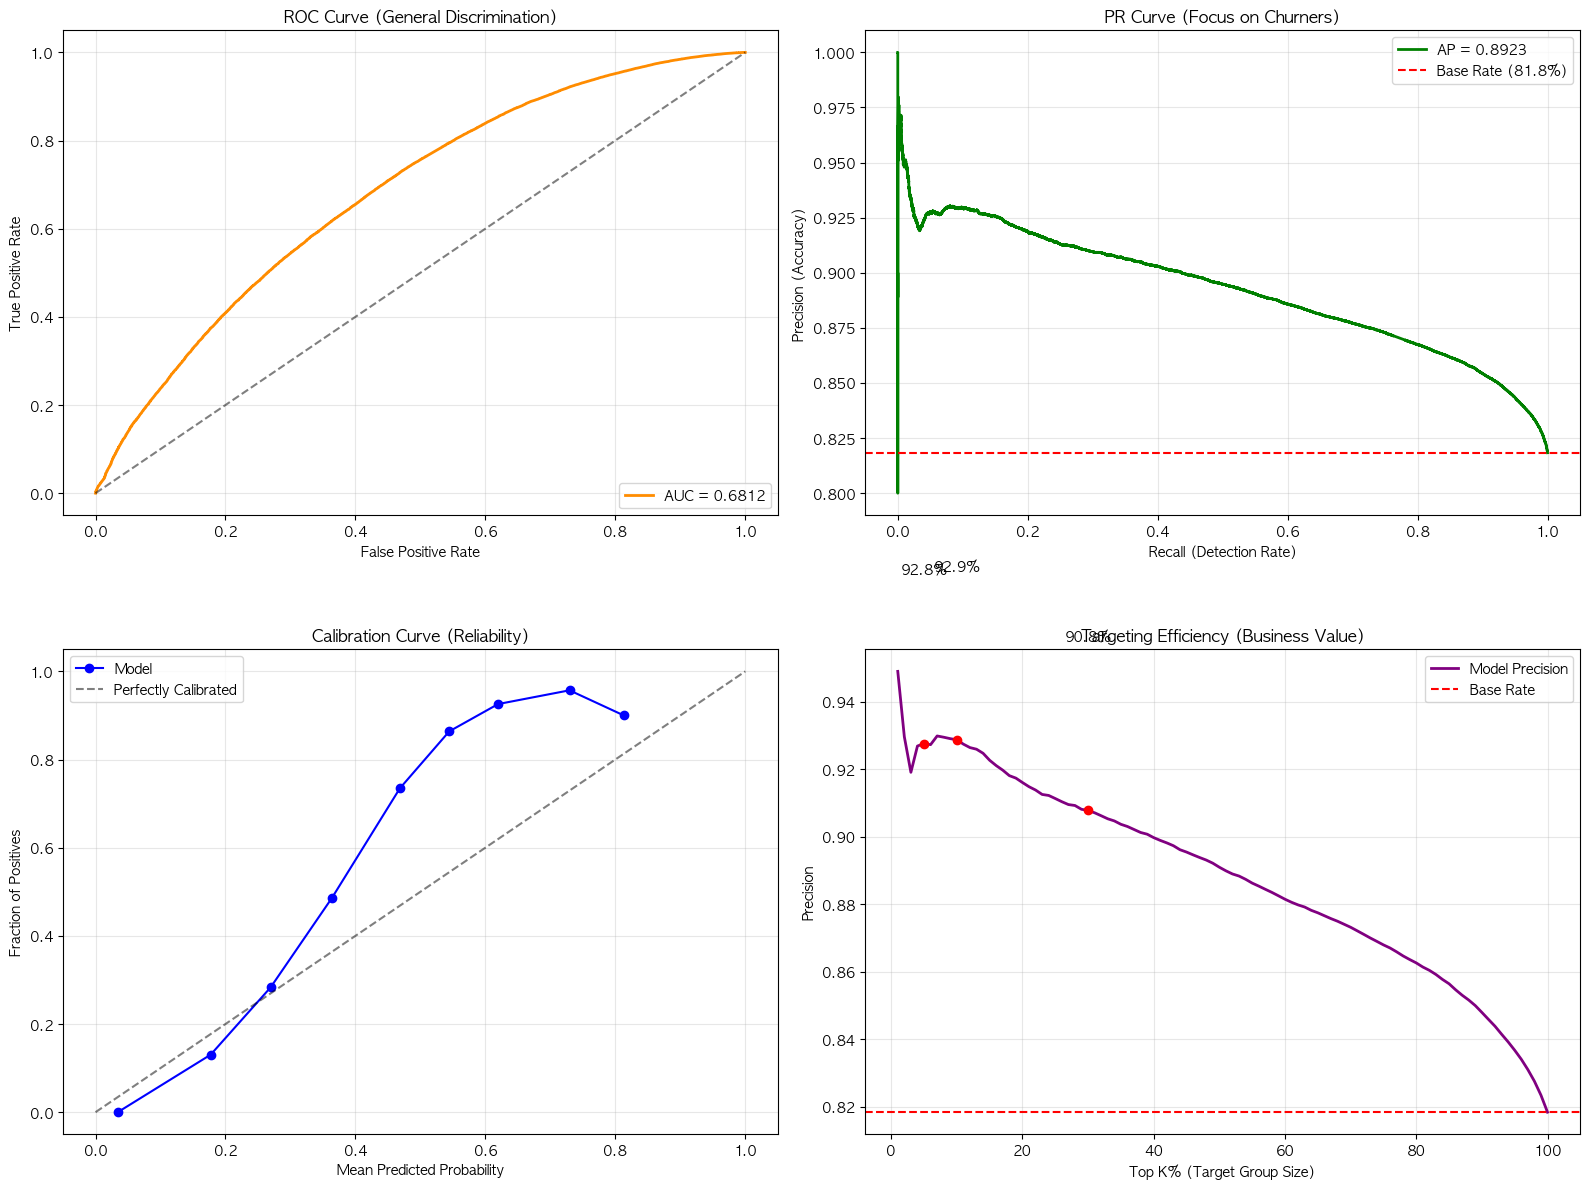

In [7]:
# --- 5. Advanced Verification (Google DeepMind Style) ---
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, roc_curve, precision_recall_curve, f1_score
from sklearn.calibration import calibration_curve
from scipy.stats import ks_2samp

print('>>> Generating Advanced Verification Dashboard...')

# [평가 모드] 모델 평가 모드 전환
model.eval()
all_logits = []
all_targets = []

# [추론] 정답 없이 예측
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        all_logits.extend(outputs.squeeze().numpy())
        all_targets.extend(targets.numpy())

# [확률 변환]
all_probs = 1 / (1 + np.exp(-np.array(all_logits)))
df_res = pd.DataFrame({'prob': all_probs, 'label': all_targets})
df_res = df_res.sort_values('prob', ascending=False)

# --- [1] Summary Metrics ---
roc_auc = roc_auc_score(all_targets, all_probs)
ap_score = average_precision_score(all_targets, all_probs)
brier = brier_score_loss(all_targets, all_probs)

# KS Statistic
class0_probs = df_res[df_res['label'] == 0]['prob']
class1_probs = df_res[df_res['label'] == 1]['prob']
ks_stat, ks_pval = ks_2samp(class1_probs, class0_probs)

summary_df = pd.DataFrame({
    'Metric': ['ROC-AUC', 'Average Precision (AP)', 'KS Statistic', 'Brier Score'],
    'Value': [roc_auc, ap_score, ks_stat, brier],
    'Interpretation': [
        '전체적인 변별력 (0.5=랜덤, 1.0=완벽)',
        '소수 클래스(이탈자) 찾기 실력',
        '두 집단(이탈/유지)의 분리 정도 (최대 차이)',
        '확률값의 정확도 (0에 가까울수록 좋음)'
    ]
})
print('\n[Summary Metrics]')
print(summary_df.round(4).to_string(index=False))

# --- [2] Ranking Performance (Top K%) ---
base_rate = df_res['label'].mean()
results = []
thresholds_pct = [5, 10, 15, 30]
for k in thresholds_pct:
    top_k_count = int(len(df_res) * (k/100))
    top_k_df = df_res.iloc[:top_k_count]
    precision = top_k_df['label'].mean()
    lift = precision / base_rate
    results.append({'Top K%': f'{k}%', 'Precision': f'{precision*100:.2f}%', 'Lift': f'{lift:.2f}x'})

print('\n[Ranking Performance]')
print(pd.DataFrame(results).to_string(index=False))

# --- [3] Dashboard Visualization (2x2) ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3)

# (1) ROC Curve
fpr, tpr, _ = roc_curve(all_targets, all_probs)
axes[0, 0].plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', color='darkorange', lw=2)
axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0, 0].set_title('ROC Curve (General Discrimination)')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(True, alpha=0.3)

# (2) PR Curve
precision_curve, recall_curve, _ = precision_recall_curve(all_targets, all_probs)
axes[0, 1].plot(recall_curve, precision_curve, label=f'AP = {ap_score:.4f}', color='green', lw=2)
axes[0, 1].axhline(y=base_rate, color='r', linestyle='--', label=f'Base Rate ({base_rate*100:.1f}%)')
axes[0, 1].set_title('PR Curve (Focus on Churners)')
axes[0, 1].set_xlabel('Recall (Detection Rate)')
axes[0, 1].set_ylabel('Precision (Accuracy)')
axes[0, 1].legend(loc='upper right')
axes[0, 1].grid(True, alpha=0.3)

# (3) Calibration Curve
prob_true, prob_pred = calibration_curve(all_targets, all_probs, n_bins=10)
axes[1, 0].plot(prob_pred, prob_true, marker='o', label='Model', color='blue')
axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfectly Calibrated')
axes[1, 0].set_title('Calibration Curve (Reliability)')
axes[1, 0].set_xlabel('Mean Predicted Probability')
axes[1, 0].set_ylabel('Fraction of Positives')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# (4) Efficiency Curve (Top K%)
k_values = np.linspace(1, 100, 100)
precisions = []
for k in k_values:
    count = int(len(df_res) * (k/100))
    if count == 0: count = 1
    prec = df_res.iloc[:count]['label'].mean()
    precisions.append(prec)

axes[1, 1].plot(k_values, precisions, label='Model Precision', color='purple', lw=2)
axes[1, 1].axhline(y=base_rate, color='r', linestyle='--', label=f'Base Rate')
axes[1, 1].set_title('Targeting Efficiency (Business Value)')
axes[1, 1].set_xlabel('Top K% (Target Group Size)')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Annotation for Top K
for k in [5, 10, 30]:
    p = precisions[int(k)-1]
    axes[1, 1].plot(k, p, 'ro')
    axes[1, 1].text(k, p+0.05, f'{p*100:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
import os
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt

print(">>> [System] Starting Artifact Saving Pipeline...")

# 1. Define Paths
PATH_MODELS = "../../models/dl/"
PATH_METRICS = "../../models/metrics/"
PATH_ASSETS = "../../assets/training/"
PATH_REPORTS = "../../reports/training/"

for path in [PATH_MODELS, PATH_METRICS, PATH_ASSETS, PATH_REPORTS]:
    os.makedirs(path, exist_ok=True)

# 2. Save Model
model_path = os.path.join(PATH_MODELS, "MLP_advanced_model.pt")
torch.save(model.state_dict(), model_path)

# 3. Save Metrics
metrics_data = {
    "summary": summary_df.to_dict(orient="records"),
    "ranking": results
}
with open(os.path.join(PATH_METRICS, "MLP_advanced_metrics.json"), "w", encoding="utf-8") as f:
    json.dump(metrics_data, f, ensure_ascii=False, indent=4)

# 4. Save Plots
fig.savefig(os.path.join(PATH_ASSETS, "MLP_advanced_dashboard.png"))

# 5. Save Report
report_content = f"# Final Benchmark Report - MLP_advanced\n\n## Summary Metrics\n{summary_df.to_markdown(index=False)}\n\n## Ranking Performance\n{pd.DataFrame(results).to_markdown(index=False)}"
with open(os.path.join(PATH_REPORTS, "MLP_advanced_report.md"), "w", encoding="utf-8") as f:
    f.write(report_content)

print("✅ [System] 모든 결과물이 ../../models/ 및 ../../reports/ 경로에 성공적으로 저장되었습니다.")

>>> [System] Starting Artifact Saving Pipeline...
✅ [System] 모든 결과물이 ../../models/ 및 ../../reports/ 경로에 성공적으로 저장되었습니다.
